In [515]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.special import boxcox1p 


In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [465]:
def RMSLE (y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [518]:
def normalized(data):
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    norm = pd.DataFrame(x_scaled)
    norm.columns = data.columns
    return norm

In [468]:
def box_transform(data):    
    for c in ['year']:
        lbl = LabelEncoder()
        lbl.fit(list(data[c].values))
        data[c] = lbl.transform(list(data[c].values))
    #shape
    print('Shape data: {}'.format(data.shape))

    #log transform skewed numeric features 
    numeric_features = data.dtypes[data.dtypes != "object"].index

    skewed_features = data[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    #compute skewness
    print ("\skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_features})   


    skewness = skewness[abs(skewness) > 0.75]
    print ("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))

    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        data[feat] = boxcox1p(data[feat], lam)

    return pd.get_dummies(data)

In [469]:
def plot_clouds(model, X, Y):
    pred = np.expm1(model.predict(X.values))
    pred = (model.predict(X.values))
    ensemble = pred * 1
    submit = pd.DataFrame()
    submit['price_per_m'] = ensemble

    mape = np.mean(np.abs((Y - submit['price_per_m']) / Y)) * 100 
    mpe = np.mean(((Y - submit['price_per_m']) / Y)) * 100 
    rmsle = RMSLE(Y, submit['price_per_m']) 
    print(f'mape: {mape}\nmpe: {mpe},\nrmsle: {rmsle}')
    y1 = (np.array(Y))
    y2 = np.array(submit['price_per_m'])
    x = np.arange(len(y1))

    m = np.argsort(y1)

    y1 = y1[m]
    y2 = y2[m]

    plt.scatter(x, y2)
    plt.scatter(x, y1)
    return mape, rmsle
    

In [443]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


In [446]:
def train_model(model, X, Y):
    model.fit(X.values, Y)
    print("Accuracy score: ", model.score(X.values, Y)) 
    return model, model.score(X.values, Y)          

In [498]:
def forest(n_estimators=20, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False):
    return RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, min_impurity_split=min_impurity_split, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=verbose, warm_start=warm_start)

In [490]:
def gboost(loss='huber', learning_rate=0.05, n_estimators=3000,
                                   min_samples_split=10, min_samples_leaf=15,max_depth=10,
                                   random_state=5,max_features='sqrt'):
    return GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,max_depth=max_depth,
                                   random_state=random_state,max_features=max_features)

In [508]:
def svr(kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1):
    return SVR(kernel=kernel,degree=degree,gamma=gamma,coef0=coef0,tol=tol,C=C,epsilon=epsilon,shrinking=shrinking,cache_size=cache_size,verbose=verbose,max_iter=max_iter)

In [447]:
def lasso(alpha=0.0005, random_state=1):
    return make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=random_state))


In [448]:
def averaged(m1, m2):
    averaged_models = AveragingModels(models = (m1, m2))

In [531]:
spb_data = pd.read_csv("./datasets/initial/spb.csv")
spb_data = spb_data[spb_data['median_salaries_1000'] != 0]
spb_data['year'] = spb_data['year'].fillna(0)
spb_data = spb_data[spb_data['year'] != 0]
spb_data = spb_data[spb_data['year'] != 1]

spb_data = spb_data[spb_data['price_per_m'] <= 400]
spb_data = spb_data[spb_data['price_per_m'] >= 20]


In [532]:
spb_data['year'] = spb_data['year'].apply(int).apply(str)
#Label Encoding some categorical variables
#for information in their ordering set

cols = ['year']
#apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(spb_data[c].values))
    spb_data[c] = lbl.transform(list(spb_data[c].values))
#shape
print('Shape data: {}'.format(spb_data.shape))
#spb_data['Id'] = [i for i in range(spb_data.shape[0])]


Shape data: (4028, 49)


In [533]:
spb_data['year'].head()

0    102
1     94
2     89
3     91
5    196
Name: year, dtype: int64

In [576]:
X = (spb_data[[c for c in spb_data.columns if c not in ['price', 'area','rooms', 'price_per_m']]])
#X['year'] = spb_data['year']
#X = (spb_data[['year', 'distance_to_center', 'distance_to_bus_stop', 'distance_to_subway', 'vacancy_1000', 'mean_salaries_1000', 'point_of_interest_1000']])
Y = (spb_data['price_per_m'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
#X_train = box_transform(X_train)
#X_test = box_transform(X_test)
#Y_train = np.log1p(Y_train)
#Y_test = np.log1p(Y_test)

#save the ID column
#train_ID = X_train['Id']
#test_ID = X_test['Id']

#Drop the ID column since it is unnecessary for the prediction process
#X_train.drop("Id", axis=1, inplace=True)
#X_test.drop("Id", axis=1, inplace=True)

model = gboost()
trained_model = train_model(model, X_train, Y_train)


Accuracy score:  0.9289544038971669


In [577]:
trained_model[0].score(X_test, Y_test)

0.6134491852383637

mape: 36.51693086580936
mpe: -3.4449328664399546,
rmsle: 37.3659517586584


(36.51693086580936, 37.3659517586584)

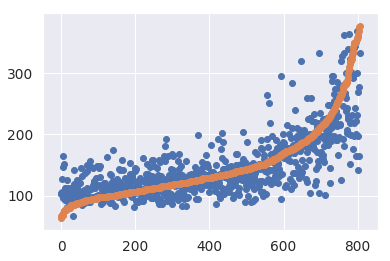

In [578]:
plot_clouds(trained_model[0], X_test, Y_test)

In [561]:
avg = AveragingModels(models=[gboost(), forest()])
avg.fit(X_train, Y_train)

AveragingModels(models=[GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=10,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min...mators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)])

In [563]:
avg.score(X_test, Y_test)

0.6320947982633465

mape: 37.17400086322414
mpe: -5.065595849178541,
rmsle: 36.453624559167885


(37.17400086322414, 36.453624559167885)

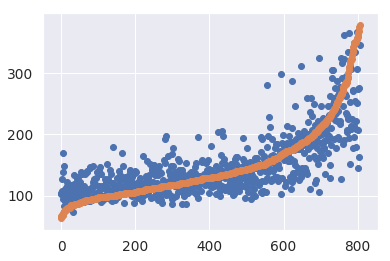

In [562]:
plot_clouds(avg, X_test, Y_test)

mape: 36.51693086580936
mpe: -3.4449328664399546,
rmsle: 37.3659517586584


(36.51693086580936, 37.3659517586584)

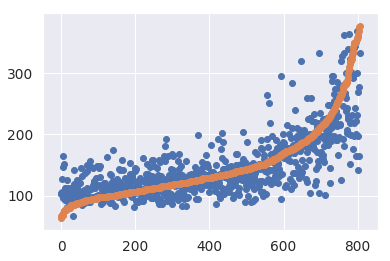

In [439]:
abbr = 'smr'
smr_data = pd.read_csv(f'./datasets/initial/{abbr}.csv')
smr_data = smr_data[smr_data['price_per_m'] <= 150]
smr_data = smr_data[smr_data['price_per_m'] >= 10]
smr_data['Id'] = [i for i in range(smr_data.shape[0])]

In [440]:
X = (smr_data[[c for c in smr_data.columns if c not in ['price', 'year', 'area', 'rooms', 'price_per_m']]])
Y = (smr_data['price_per_m'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [441]:
#save the ID column
train_ID = X_train['Id']
test_ID = X_test['Id']

#Drop the ID column since it is unnecessary for the prediction process
X_train.drop("Id", axis=1, inplace=True)
X_test.drop("Id", axis=1, inplace=True)


/home/disa/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Accuracy score:  0.8002851734047141
mape: 22.977194908946213
mpe: -4.236840162706854


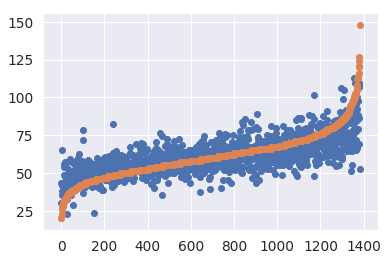

In [442]:
model = trained_gboost(X_train, Y_train)
plot_clouds(model, X_test, Y_test)

/home/disa/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Accuracy score:  0.8501359414312638


mape: 41.761233987169476
mpe: -11.848725154829744


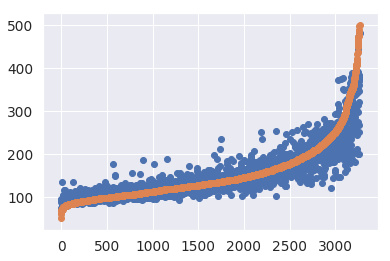

In [358]:
X_test.shape

(817, 46)

In [357]:
Y_test.shape

(817,)

In [310]:
#validation function
n_folds = 5

def RMSLE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error",
cv = kf))
    return(rmse)


In [311]:
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))

#Gradient Boosting Regression
GBoost = GradientBoostingRegressor(loss='huber', learning_rate=0.05, n_estimators=3000,
                                   min_samples_split=10, min_samples_leaf=15,max_depth=4,
                                   random_state=5,max_features='sqrt')



###### scores from the above models


In [312]:
#Lasso
score = RMSLE_cv(lasso)
print ("\n Lasso score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

#Gradient Boosting Regression
score = RMSLE_cv(GBoost)
print ("\n GBoost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))


 Lasso score: 0.2967 (0.0068)


 GBoost score: 0.2293 (0.0107)




#### stacking the models 

###### averaging base model


In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


    
# Averaged base models score

averaged_models = AveragingModels(models = (GBoost, lasso))

score = RMSLE_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [314]:
#defining RMSLE evaluation function


In [ ]:
GBoost.fit(train.values, y_train) 


In [323]:
GBoost.score(train.values, y_train)

0.8904026035321058

In [332]:
#final training and prediction of the stacked regressor

averaged_models.fit(train.values, y_train) 
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
print("RMSLE score on the train data:") 
print(RMSLE(y_train,stacked_train_pred))


TypeError: Cannot clone object 'array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=4,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f0ec1297d38>,
           splitter='best')], dtype=object)' (type <class 'numpy.ndarray'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

,id,SalePrice
688,599,150.030679
873,752,125.682289
3208,2775,116.767843
3388,2929,193.424050
2895,2513,135.738568


In [330]:
mape

16.652978226683445

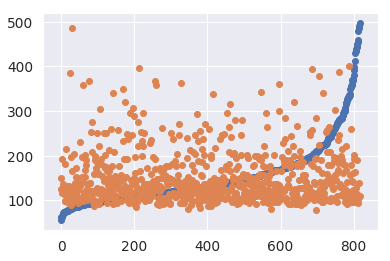

In [279]:
import matplotlib.pyplot as plt


(array([64., 75., 68., 67., 61., 57., 49., 50., 48., 34., 31., 32., 26.,
        12., 21., 20., 13., 10., 16.,  9.,  6.,  3.,  4.,  3.,  4.,  7.,
         3.,  1.,  5.,  3.,  3.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([1.58367296e-04, 2.14124863e-02, 4.26666053e-02, 6.39207243e-02,
        8.51748433e-02, 1.06428962e-01, 1.27683081e-01, 1.48937200e-01,
        1.70191319e-01, 1.91445438e-01, 2.12699557e-01, 2.33953676e-01,
        2.55207795e-01, 2.76461914e-01, 2.97716033e-01, 3.18970152e-01,
        3.40224271e-01, 3.61478390e-01, 3.82732509e-01, 4.03986628e-01,
        4.25240747e-01, 4.46494866e-01, 4.67748985e-01, 4.89003104e-01,
        5.10257223e-01, 5.31511342e-01, 5.52765461e-01, 5.74019580e-01,
        5.95273699e-01, 6.16527818e-01, 6.37781937e-01, 6.59036056e-01,
        6.80290175e-01, 7.01544294e-01, 7.22798413e-01, 7.44052532e-01,
        7.65306651e-01, 7.86560770e-01, 8.07814889e-01, 8.29069008e-

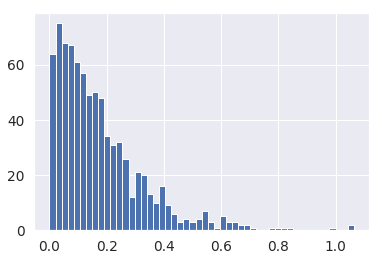

In [282]:
plt.hist(egg, 50)

NameError: name 'arange' is not defined